# All imports

This file contains code for EfficientNetB0 and Xception models (CPU)

In [1]:
import cv2
import os
import random
from google.colab import drive
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Concatenate, Input, Add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Drive Set up

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
input_dirs = {
    'rotten': '/content/drive/MyDrive/data/rotten',
    'mid': '/content/drive/MyDrive/data/mid',
    'fresh': '/content/drive/MyDrive/data/fresh'
}

In [4]:
output_dirs = {
    'rotten': '/content/drive/MyDrive/data/rotten_frames',
    'mid': '/content/drive/MyDrive/data/mid_frames',
    'fresh': '/content/drive/MyDrive/data/fresh_frames'
}

In [5]:
for category, out_dir in output_dirs.items():
    os.makedirs(out_dir, exist_ok=True)

# Dataset Preparation

## Frame Extraction

In [6]:
fresh_frames_dir = '/content/drive/MyDrive/data/fresh_frames'
mid_frames_dir = '/content/drive/MyDrive/data/mid_frames'
rotten_frames_dir = '/content/drive/MyDrive/data/rotten_frames'

fresh_images_count = len([file for file in os.listdir(fresh_frames_dir) if file.endswith('.jpg')])
mid_images_count = len([file for file in os.listdir(mid_frames_dir) if file.endswith('.jpg')])
rotten_images_count = len([file for file in os.listdir(rotten_frames_dir) if file.endswith('.jpg')])

print(f"Number of images in fresh_frames: {fresh_images_count}")
print(f"Number of images in mid_frames: {mid_images_count}")
print(f"Number of images in rotten_frames: {rotten_images_count}")

Number of images in fresh_frames: 110
Number of images in mid_frames: 130
Number of images in rotten_frames: 60


## Data preprocessing

In [7]:
base_path = "/content/drive/MyDrive/data/augmented"

folders = {
    "fresh": "augmented_fresh_frames",
    "mid": "augmented_mid_frames",
    "rotten": "augmented_rotten_frames"
}

for label, folder in folders.items():
    folder_path = os.path.join(base_path, folder)
    count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
    print(f"Number of images in {folder}: {count}")

Number of images in augmented_fresh_frames: 1100
Number of images in augmented_mid_frames: 1300
Number of images in augmented_rotten_frames: 600


In [8]:
rotten_dir = os.path.join(base_path, 'augmented_rotten_frames')
mid_dir = os.path.join(base_path, 'augmented_mid_frames')
fresh_dir = os.path.join(base_path, 'augmented_fresh_frames')

In [9]:
# Class weights (handle imbalance)
total_images = {
    'rotten': 600,
    'mid': 1300,
    'fresh': 1100
}

total = sum(total_images.values())

# 0 - rotten, 1 - mid, 2 - fresh
class_weights = {
    0: int(total / total_images['rotten']),  # rotten
    1: int(total / total_images['mid']),     # mid
    2: int(total / total_images['fresh'])    # fresh
}

print("Class Weights:", class_weights)

Class Weights: {0: 5, 1: 2, 2: 2}


In [10]:
batch_size = 32
img_size = (224, 224)

datagen = ImageDataGenerator(
    validation_split=0.3,
)
#Training data
train_data = datagen.flow_from_directory(
    base_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)
#Validation data
val_data = datagen.flow_from_directory(
    base_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 2100 images belonging to 3 classes.
Found 900 images belonging to 3 classes.


# Models Training

## EfficientNetB0

In [ ]:
from tensorflow.keras.applications.efficientnet import preprocess_input

datagen_preprocessed = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.3
)

#Training data
train_data_efficientnet = datagen_preprocessed.flow_from_directory(
    base_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

#Validation data
val_data_efficientnet = datagen_preprocessed.flow_from_directory(
    base_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 2100 images belonging to 3 classes.
Found 900 images belonging to 3 classes.


In [ ]:
from tensorflow.keras.applications import EfficientNetB0

#Loading EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

#Model Building
model_efficientnet = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(3, activation='softmax')
])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
#compilation
model_efficientnet.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

#Model summary
model_efficientnet.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,378,278 (16.70 MB)

 Trainable params: 328,707 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import time

# Callbacks
checkpoint_efficientnet = ModelCheckpoint(
    'efficientnet_cpu.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

reduce_lr_efficientnet = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

early_stopping_efficientnet = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Start training
start_efficientnet = time.time()

history_efficientnet = model_efficientnet.fit(
    train_data_efficientnet,
    epochs=50,
    validation_data=val_data_efficientnet,
    callbacks=[checkpoint_efficientnet, reduce_lr_efficientnet, early_stopping_efficientnet]
)

end_efficientnet = time.time()
runtime_efficientnet = end_efficientnet - start_efficientnet

print(f"Training Time for EfficientNetB0 model: {runtime_efficientnet:.2f} seconds")

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.8081 - loss: 0.4690 
Epoch 1: val_accuracy improved from -inf to 0.94778, saving model to efficientnet_cpu.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 1056s 16s/step - accuracy: 0.8093 - loss: 0.4666 - val_accuracy: 0.9478 - val_loss: 0.1373 - learning_rate: 0.0010
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9379 - loss: 0.1520
Epoch 2: val_accuracy did not improve from 0.94778
66/66 ━━━━━━━━━━━━━━━━━━━━ 240s 4s/step - accuracy: 0.9380 - loss: 0.1520 - val_accuracy: 0.9367 - val_loss: 0.1183 - learning_rate: 0.0010
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9450 - loss: 0.1274
Epoch 3: val_accuracy did not improve from 0.94778
66/66 ━━━━━━━━━━━━━━━━━━━━ 253s 4s/step - accuracy: 0.9450 - loss: 0.1273 - val_accuracy: 0.9356 - val_loss: 0.1229 - learning_rate: 0.0010
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9412 - loss: 0.1327
Epoch 4: val_accuracy improved from 0.94778 to 0.95778, saving model to efficientnet_cpu.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 260s 4s/step - accuracy: 0.9412 - loss: 0.1325 - val_accuracy: 0.9578 - val_loss: 0.0902 - learning_rate: 0.0010
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9483 - loss: 0.1185
Epoch 5: val_accuracy did not improve from 0.95778
66/66 ━━━━━━━━━━━━━━━━━━━━ 262s 4s/step - accuracy: 0.9484 - loss: 0.1183 - val_accuracy: 0.9567 - val_loss: 0.0926 - learning_rate: 0.0010
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9556 - loss: 0.1066
Epoch 6: val_accuracy improved from 0.95778 to 0.95889, saving model to efficientnet_cpu.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 243s 4s/step - accuracy: 0.9556 - loss: 0.1065 - val_accuracy: 0.9589 - val_loss: 0.0846 - learning_rate: 0.0010
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9583 - loss: 0.1021
Epoch 7: val_accuracy did not improve from 0.95889
66/66 ━━━━━━━━━━━━━━━━━━━━ 228s 3s/step - accuracy: 0.9582 - loss: 0.1022 - val_accuracy: 0.9578 - val_loss: 0.0874 - learning_rate: 0.0010
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9651 - loss: 0.0822
Epoch 8: val_accuracy did not improve from 0.95889
66/66 ━━━━━━━━━━━━━━━━━━━━ 227s 3s/step - accuracy: 0.9651 - loss: 0.0822 - val_accuracy: 0.9578 - val_loss: 0.0796 - learning_rate: 0.0010
Epoch 9/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9677 - loss: 0.0736
Epoch 9: val_accuracy improved from 0.95889 to 0.96111, saving model to efficientnet_cpu.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 242s 4s/step - accuracy: 0.9676 - loss: 0.0738 - val_accuracy: 0.9611 - val_loss: 0.1109 - learning_rate: 0.0010
Epoch 10/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9590 - loss: 0.0908
Epoch 10: val_accuracy did not improve from 0.96111
66/66 ━━━━━━━━━━━━━━━━━━━━ 246s 4s/step - accuracy: 0.9590 - loss: 0.0909 - val_accuracy: 0.9589 - val_loss: 0.0747 - learning_rate: 0.0010
Epoch 11/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9601 - loss: 0.0740
Epoch 11: val_accuracy did not improve from 0.96111
66/66 ━━━━━━━━━━━━━━━━━━━━ 246s 4s/step - accuracy: 0.9601 - loss: 0.0741 - val_accuracy: 0.9611 - val_loss: 0.0709 - learning_rate: 0.0010
Epoch 12/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9608 - loss: 0.0782
Epoch 12: val_accuracy did not improve from 0.96111

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
66/66 ━━━━━━━━━━━━━━━━━━━━ 248s 4s/step - accuracy: 0.9609 - loss: 0.0782 - val_accuracy: 0.9

66/66 ━━━━━━━━━━━━━━━━━━━━ 256s 4s/step - accuracy: 0.9685 - loss: 0.0646 - val_accuracy: 0.9633 - val_loss: 0.0650 - learning_rate: 2.0000e-04
Epoch 16/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9667 - loss: 0.0594
Epoch 16: val_accuracy did not improve from 0.96333
66/66 ━━━━━━━━━━━━━━━━━━━━ 266s 4s/step - accuracy: 0.9667 - loss: 0.0594 - val_accuracy: 0.9611 - val_loss: 0.0643 - learning_rate: 2.0000e-04
Epoch 17/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9752 - loss: 0.0550
Epoch 17: val_accuracy did not improve from 0.96333
66/66 ━━━━━━━━━━━━━━━━━━━━ 265s 4s/step - accuracy: 0.9751 - loss: 0.0550 - val_accuracy: 0.9633 - val_loss: 0.0640 - learning_rate: 2.0000e-04
Epoch 18/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9651 - loss: 0.0557
Epoch 18: val_accuracy did not improve from 0.96333

Epoch 18: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
66/66 ━━━━━━━━━━━━━━━━━━━━ 266s 4s/step - accuracy: 0.9652 - loss: 0.0558 - val_a

In [ ]:
# model_efficientnet = load_model("efficientnet_cpu.h5")

In [ ]:
loss_efficientnet, accuracy_efficientnet = model_efficientnet.evaluate(val_data_efficientnet)
print(f"Validation Accuracy: {accuracy_efficientnet:.8f}, Validation Loss: {loss_efficientnet:.8f}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.9558 - loss: 0.0669
Validation Accuracy: 0.96333331, Validation Loss: 0.06498352


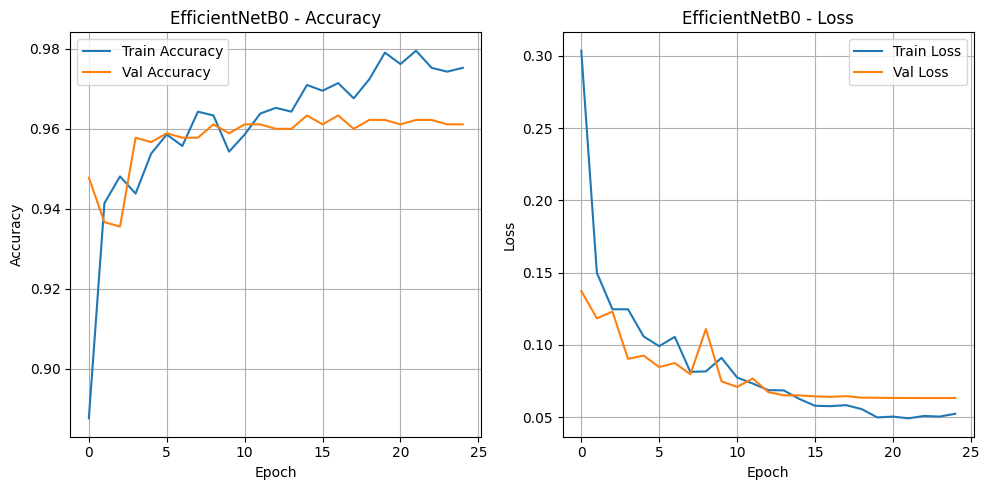

In [ ]:
#Plots for EfficientNetB0 Accuracy and loss
plt.figure(figsize=(10, 5))

#Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_efficientnet.history['accuracy'], label='Train Accuracy')
plt.plot(history_efficientnet.history['val_accuracy'], label='Val Accuracy')
plt.title('EfficientNetB0 - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

#Loss
plt.subplot(1, 2, 2)
plt.plot(history_efficientnet.history['loss'], label='Train Loss')
plt.plot(history_efficientnet.history['val_loss'], label='Val Loss')
plt.title('EfficientNetB0 - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#Cnfusion matrix
#Prediction on validation data
val_pred_efficientb0 = model_efficientnet.predict(val_data_efficientnet)
y_pred_efficientb0 = np.argmax(val_pred_efficientb0, axis=1)

y_true_efficientb0 = val_data_efficientnet.classes

class_names = list(val_data_efficientnet.class_indices.keys())

29/29 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step


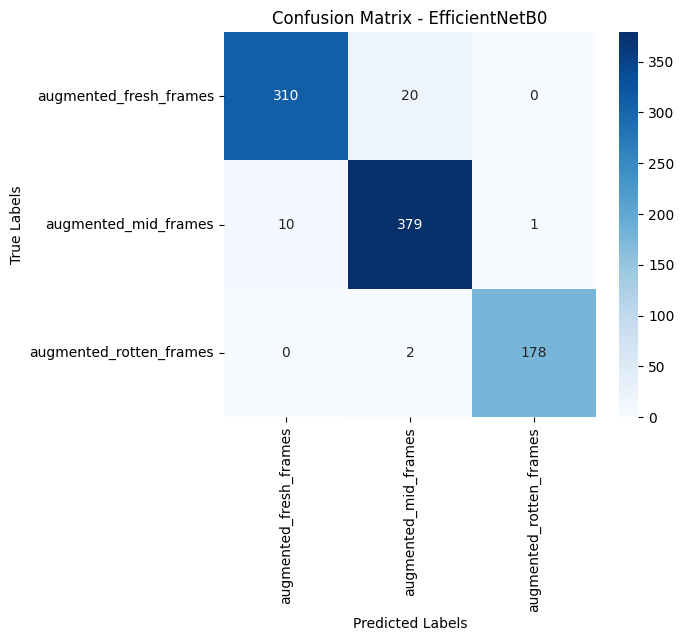

In [ ]:
cm_efficientb0 = confusion_matrix(y_true_efficientb0, y_pred_efficientb0)
#show cm
plt.figure(figsize=(6, 5))
sns.heatmap(cm_efficientb0, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - EfficientNetB0')
plt.show()

## ResNet50

## ResNet101

## Xception

In [16]:
#Scaling values using preprocess_input
from tensorflow.keras.applications.xception import Xception, preprocess_input

datagen_preprocessed = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.3
)

# Load training data using datagen_preprocessed
train_data_xception = datagen_preprocessed.flow_from_directory(
    base_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Load validation data using datagen_preprocessed
val_data_xception = datagen_preprocessed.flow_from_directory(
    base_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 2100 images belonging to 3 classes.
Found 900 images belonging to 3 classes.


In [17]:
#Loading Xception
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

#model building
model_xception = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(3, activation='softmax')
])

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
#Compilation
model_xception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#Summary
model_xception.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,386,795 (81.58 MB)

 Trainable params: 525,315 (2.00 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import time

# Callbacks
checkpoint_xception = ModelCheckpoint(
    'best_model_xception.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

reduce_lr_xception = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

early_stopping_xception = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Start training
start_xception = time.time()

history_xception = model_xception.fit(
    train_data_xception,
    epochs=50,
    validation_data=val_data_xception,
    callbacks=[checkpoint_xception, reduce_lr_xception, early_stopping_xception]
)

end_xception = time.time()
runtime_xception = end_xception - start_xception

print(f"Training Time for Xception model: {runtime_xception:.2f} seconds")

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7768 - loss: 0.5783
Epoch 1: val_accuracy improved from -inf to 0.88778, saving model to best_model_xception.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 1064s 16s/step - accuracy: 0.7779 - loss: 0.5757 - val_accuracy: 0.8878 - val_loss: 0.2724 - learning_rate: 0.0010
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9076 - loss: 0.2428
Epoch 2: val_accuracy improved from 0.88778 to 0.92556, saving model to best_model_xception.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 632s 10s/step - accuracy: 0.9078 - loss: 0.2424 - val_accuracy: 0.9256 - val_loss: 0.1883 - learning_rate: 0.0010
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9251 - loss: 0.1844
Epoch 3: val_accuracy improved from 0.92556 to 0.94111, saving model to best_model_xception.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 699s 10s/step - accuracy: 0.9253 - loss: 0.1842 - val_accuracy: 0.9411 - val_loss: 0.1493 - learning_rate: 0.0010
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9332 - loss: 0.1527
Epoch 4: val_accuracy did not improve from 0.94111
66/66 ━━━━━━━━━━━━━━━━━━━━ 627s 10s/step - accuracy: 0.9333 - loss: 0.1526 - val_accuracy: 0.9378 - val_loss: 0.1493 - learning_rate: 0.0010
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9527 - loss: 0.1303
Epoch 5: val_accuracy did not improve from 0.94111
66/66 ━━━━━━━━━━━━━━━━━━━━ 698s 10s/step - accuracy: 0.9528 - loss: 0.1302 - val_accuracy: 0.9367 - val_loss: 0.1368 - learning_rate: 0.0010
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9493 - loss: 0.1098
Epoch 6: val_accuracy improved from 0.94111 to 0.94667, saving model to best_model_xception.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 644s 10s/step - accuracy: 0.9494 - loss: 0.1098 - val_accuracy: 0.9467 - val_loss: 0.1337 - learning_rate: 0.0010
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9628 - loss: 0.0913
Epoch 7: val_accuracy improved from 0.94667 to 0.95111, saving model to best_model_xception.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 647s 10s/step - accuracy: 0.9628 - loss: 0.0913 - val_accuracy: 0.9511 - val_loss: 0.1232 - learning_rate: 0.0010
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9556 - loss: 0.1047
Epoch 8: val_accuracy improved from 0.95111 to 0.95889, saving model to best_model_xception.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 670s 10s/step - accuracy: 0.9556 - loss: 0.1048 - val_accuracy: 0.9589 - val_loss: 0.1111 - learning_rate: 0.0010
Epoch 9/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9781 - loss: 0.0759
Epoch 9: val_accuracy did not improve from 0.95889
66/66 ━━━━━━━━━━━━━━━━━━━━ 632s 10s/step - accuracy: 0.9780 - loss: 0.0760 - val_accuracy: 0.9522 - val_loss: 0.1333 - learning_rate: 0.0010
Epoch 10/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9677 - loss: 0.0758
Epoch 10: val_accuracy did not improve from 0.95889
66/66 ━━━━━━━━━━━━━━━━━━━━ 634s 10s/step - accuracy: 0.9677 - loss: 0.0759 - val_accuracy: 0.9389 - val_loss: 0.1497 - learning_rate: 0.0010
Epoch 11/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9597 - loss: 0.0852
Epoch 11: val_accuracy did not improve from 0.95889

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
66/66 ━━━━━━━━━━━━━━━━━━━━ 636s 10s/step - accuracy: 0.9597 - loss: 0.0851 - val_accuracy: 0

66/66 ━━━━━━━━━━━━━━━━━━━━ 635s 10s/step - accuracy: 0.9848 - loss: 0.0455 - val_accuracy: 0.9611 - val_loss: 0.1030 - learning_rate: 2.0000e-04
Epoch 15/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9811 - loss: 0.0455
Epoch 15: val_accuracy did not improve from 0.96111
66/66 ━━━━━━━━━━━━━━━━━━━━ 632s 10s/step - accuracy: 0.9812 - loss: 0.0455 - val_accuracy: 0.9589 - val_loss: 0.1051 - learning_rate: 2.0000e-04
Epoch 16/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9857 - loss: 0.0395
Epoch 16: val_accuracy did not improve from 0.96111
66/66 ━━━━━━━━━━━━━━━━━━━━ 646s 10s/step - accuracy: 0.9856 - loss: 0.0396 - val_accuracy: 0.9589 - val_loss: 0.1033 - learning_rate: 2.0000e-04
Epoch 17/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9867 - loss: 0.0430
Epoch 17: val_accuracy did not improve from 0.96111

Epoch 17: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
66/66 ━━━━━━━━━━━━━━━━━━━━ 681s 10s/step - accuracy: 0.9867 - loss: 0.0430 - v

In [20]:
model_xception = load_model("best_model_xception.h5")

In [21]:
loss_xception, accuracy_xception = model_xception.evaluate(val_data_xception)
print(f"Validation Accuracy: {accuracy_xception:.4f}, Validation Loss: {loss_xception:.4f}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 195s 7s/step - accuracy: 0.9571 - loss: 0.1116
Validation Accuracy: 0.9611, Validation Loss: 0.1030


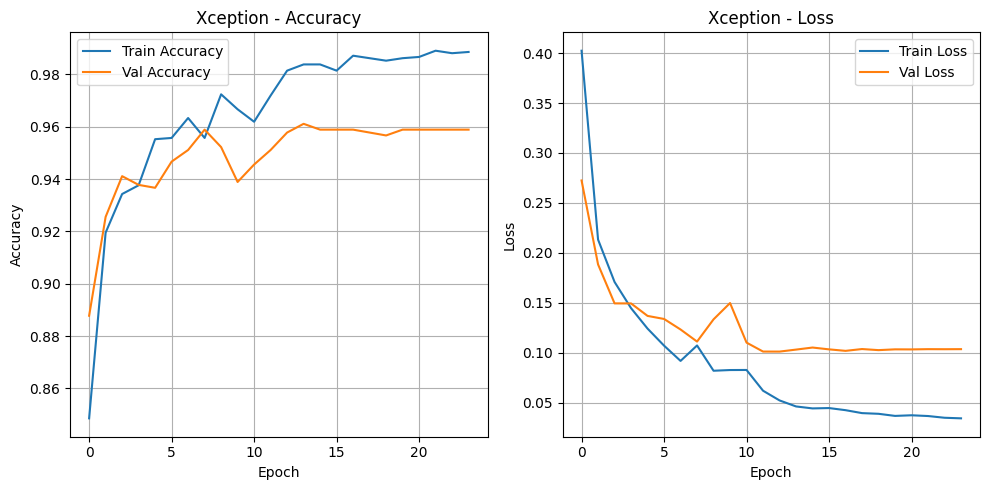

In [22]:
#Plots for Xception Accuracy and loss
plt.figure(figsize=(10, 5))

#Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_xception.history['accuracy'], label='Train Accuracy')
plt.plot(history_xception.history['val_accuracy'], label='Val Accuracy')
plt.title('Xception - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

#Loss
plt.subplot(1, 2, 2)
plt.plot(history_xception.history['loss'], label='Train Loss')
plt.plot(history_xception.history['val_loss'], label='Val Loss')
plt.title('Xception - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [26]:
#Prediction on validation data
val_pred_xception = model_xception.predict(val_data_xception)
y_pred_xception = np.argmax(val_pred_xception, axis=1)

y_true_xception = val_data_xception.classes

class_names = list(val_data_xception.class_indices.keys())

29/29 ━━━━━━━━━━━━━━━━━━━━ 198s 7s/step


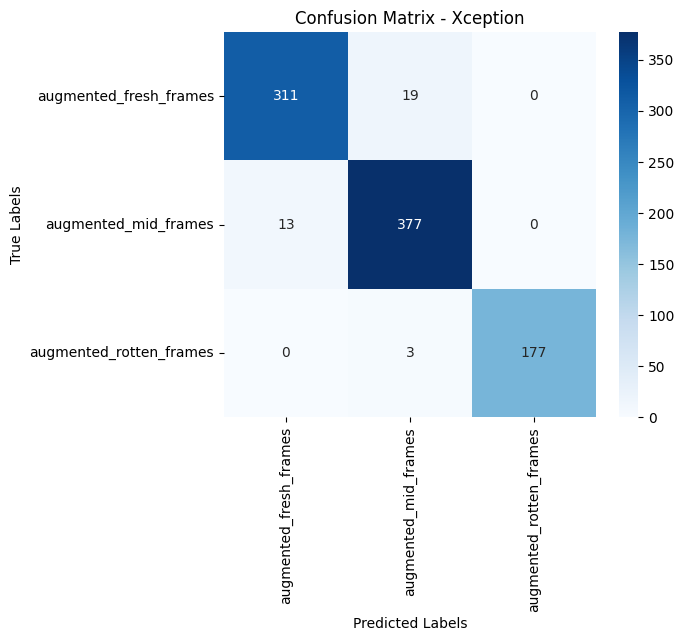

In [27]:
#confusion matrix
cm_xception = confusion_matrix(y_true_xception, y_pred_xception)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_xception, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - Xception")
plt.show()